In [1]:
import os
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import preprocessing, svm
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

### Initiate directories:

In [2]:
ROOT_DIR = os.getcwd() + '/../'
try:
    with open (ROOT_DIR + '/configuration.yml', 'r') as file:
        config = yaml.safe_load(file)
except Exception as e:
    print('Error reading the config file')
DATA_DIR = ROOT_DIR + config['data']['final'] + '/'
cities = pd.read_csv(ROOT_DIR + config['cities'])

### Cities information, eg. to loop over city names:

* **ALE:**	Alert, Canada
* **ABZ:**	Annaberg-Buchholz, Germany
* **ASP:**	Aspvreten, Sweden
* **BOT:**	Botsalano, South Africa
* **BSL:**	Bösel (Südoldenburg), Germany
* **EGB:**	Egbert, Canada
* **HEL:**	Helsinki, Finland
* **HPB:**	Hohenpeissenberg, Germany
* **HYY:**	Hyytiälä, Finland
* **KCE:**	Kosetice, Czech Republic
* **KPZ:**	K-Puszta, Hungary
* **MHD:**	Mace Head, Ireland
* **MAR:**	Marikana, South Africa
* **MLP:**	Melpitz, Germany
* **NAN:**	Nanjing, China
* **NEU:**	Neuglobsow, Germany
* **SAO:**	São Paulo, Brazil
* **SCH:**	Schauinsland, Germany
* **SGP:**	Southern Great Plains, Oklahoma, US
* **VIE:**	Vielsalm, Belgium
* **VAR:**	Värriö, Finland
* **WAL:**	Waldhof, Germany

In [3]:
cities.city.unique()

array(['ALE', 'ABZ', 'ASP', 'BOT', 'BSL', 'EGB', 'HEL', 'HPB', 'HYY',
       'KCE', 'KPZ', 'MHD', 'MAR', 'MLP', 'NAN', 'NEU', 'SAO', 'SCH',
       'SGP', 'VIE', 'VAR', 'WAL'], dtype=object)

In [4]:
city = cities.city[6]
city

'HEL'

### Open data file:

In [5]:
df = pd.read_csv(DATA_DIR + city + '.csv', index_col='date')
df.head()

,concentration,t,co
date,,,
2005-01-01,745.769167,271.50780,1.924972e-07
2005-01-02,374.991806,272.57120,1.903695e-07
2005-01-03,265.290294,272.60297,1.779340e-07
2005-01-04,304.682014,270.91785,2.032431e-07
2005-01-05,409.387986,272.37310,2.047700e-07


In [6]:
# calculating moving averages
df_ma = df.copy()
df_ma = df_ma.rolling(window=30).mean()

# normalizing the data
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(x_scaled)
df_scaled.columns = df.columns.values

# log-transforming the data
df_log = df_scaled.transform(np.log)

# calculating moving averages for log-transformed data
df_log_ma = df_log.copy()
df_log_ma = df_log_ma.rolling(window=30).mean()

In [8]:
df_scaled.head()

,concentration,t,co
0,0.088144,0.406259,0.133595
1,0.040896,0.430218,0.131089
2,0.026917,0.430934,0.116442
3,0.031937,0.392967,0.146251
4,0.045279,0.425755,0.148049


### Visualizations:

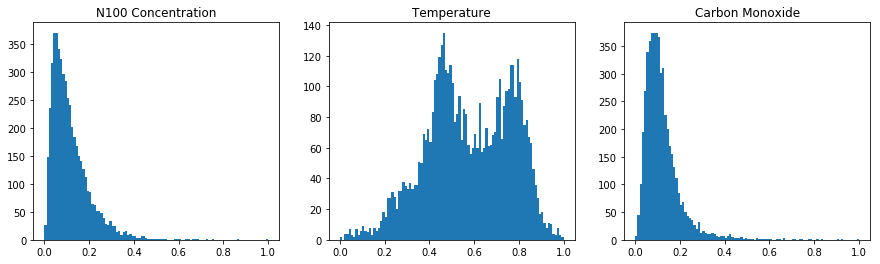

In [9]:
# plotting value distributions
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.set_figheight(4)

ax[0].hist(df_scaled.concentration, bins=100)
ax[1].hist(df_scaled.t, bins=100)
ax[2].hist(df_scaled.co, bins=100)

ax[0].set_title('N100 Concentration')
ax[1].set_title('Temperature')
ax[2].set_title('Carbon Monoxide');

N100 Concentration and Carbon Monoxide have a high positive skew and should therefore be log-tranformed

In [11]:
# removing rows that contain infinity (removes three rows)
df_log_subset = df_log.loc[np.isinf(df_log).any(axis=1) == False]
df_scaled_subset = df_scaled.loc[np.isinf(df_log).any(axis=1) == False]

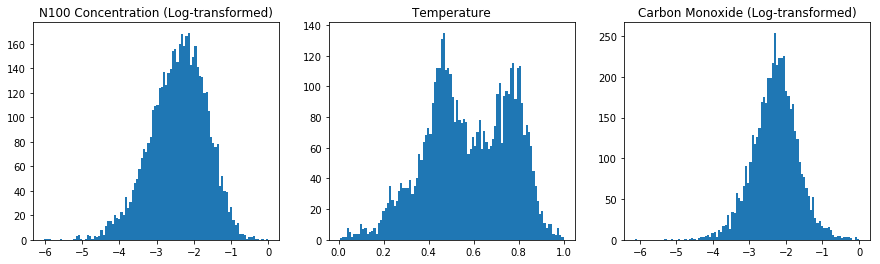

In [14]:
# plotting value distributions
fig, ax = plt.subplots(1, 3)
fig.set_figwidth(15)
fig.set_figheight(4)

ax[0].hist(df_log_subset.concentration, bins=100)
ax[1].hist(df_scaled_subset.t, bins=100)
ax[2].hist(df_log_subset.co, bins=100)

ax[0].set_title('N100 Concentration (Log-transformed)')
ax[1].set_title('Temperature')
ax[2].set_title('Carbon Monoxide (Log-transformed)');

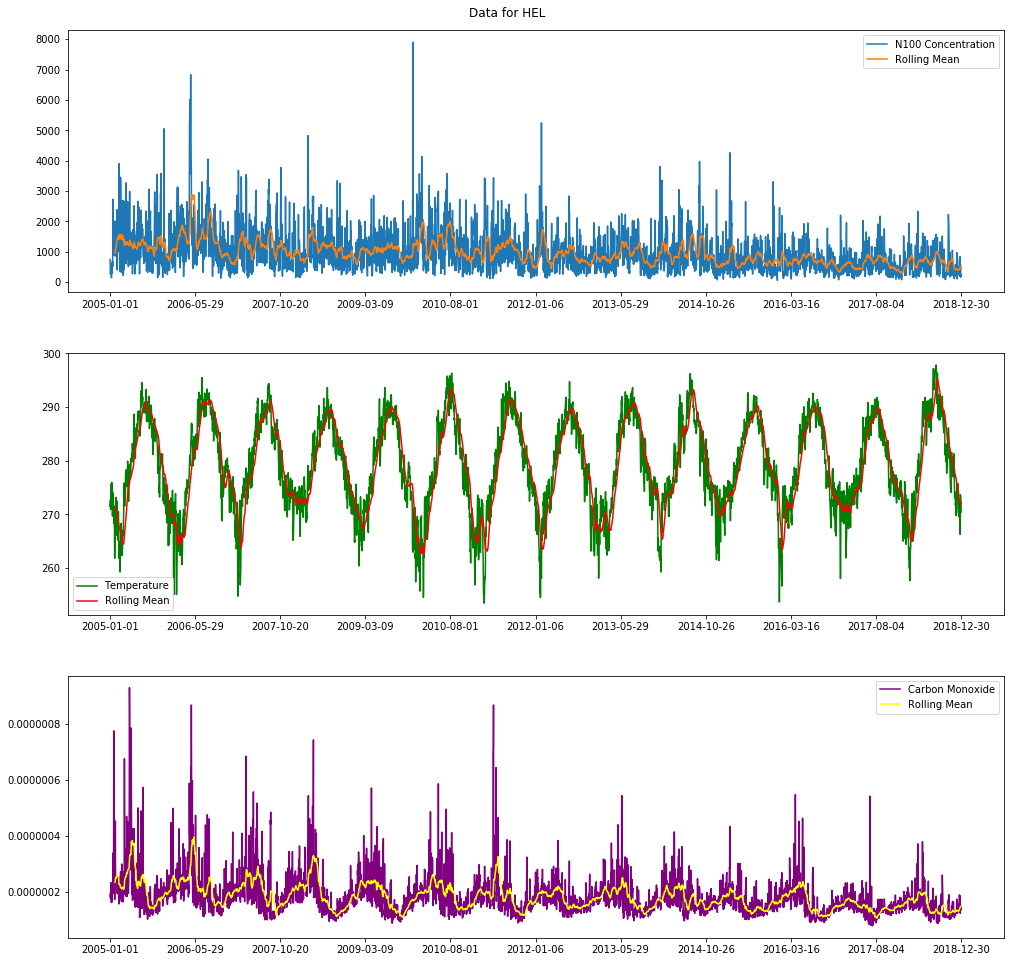

In [8]:
# plotting original data and trend (moving average)
idx = df.shape[0]
step = int(idx / 10)
xticks = pd.Series(df.index).iloc[list(range(0,idx,step))]

fig, ax = plt.subplots(3, 1)
fig.set_figwidth(15)
fig.set_figheight(14)

ax[0].plot(df.concentration[:idx], label='N100 Concentration')
ax[0].plot(df_ma.concentration[:idx], label='Rolling Mean')

ax[1].plot(df.t[:idx], label='Temperature', c='green')
ax[1].plot(df_ma.t[:idx], label='Rolling Mean', c='red')

ax[2].plot(df.co[:idx], label='Carbon Monoxide', c='purple')
ax[2].plot(df_ma.co[:idx], label='Rolling Mean', c='yellow')

for i in range(3):
    ax[i].legend()
    ax[i].set_xticks(xticks)

fig.tight_layout(pad=4)
fig.suptitle('Data for '+city);

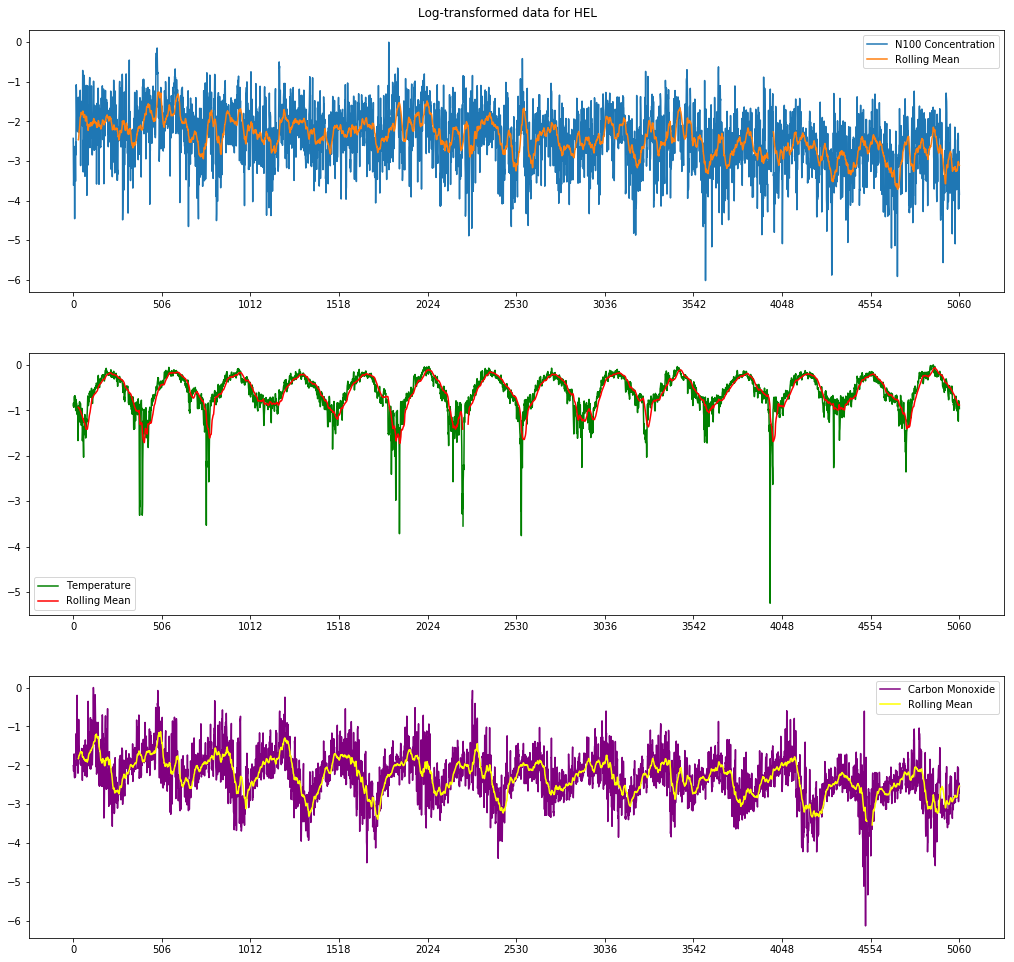

In [9]:
# plotting log-transformed data and trend (moving average)
idx = df_log.shape[0]
step = int(idx / 10)
xticks = pd.Series(df_log.index).iloc[list(range(0,idx,step))]

fig, ax = plt.subplots(3, 1)
fig.set_figwidth(15)
fig.set_figheight(14)

ax[0].plot(df_log.concentration[:idx], label='N100 Concentration')
ax[0].plot(df_log_ma.concentration[:idx], label='Rolling Mean')

ax[1].plot(df_log.t[:idx], label='Temperature', c='green')
ax[1].plot(df_log_ma.t[:idx], label='Rolling Mean', c='red')

ax[2].plot(df_log.co[:idx], label='Carbon Monoxide', c='purple')
ax[2].plot(df_log_ma.co[:idx], label='Rolling Mean', c='yellow')

for i in range(3):
    ax[i].legend()
    ax[i].set_xticks(xticks)

fig.tight_layout(pad=4)
fig.suptitle('Log-transformed data for '+city);

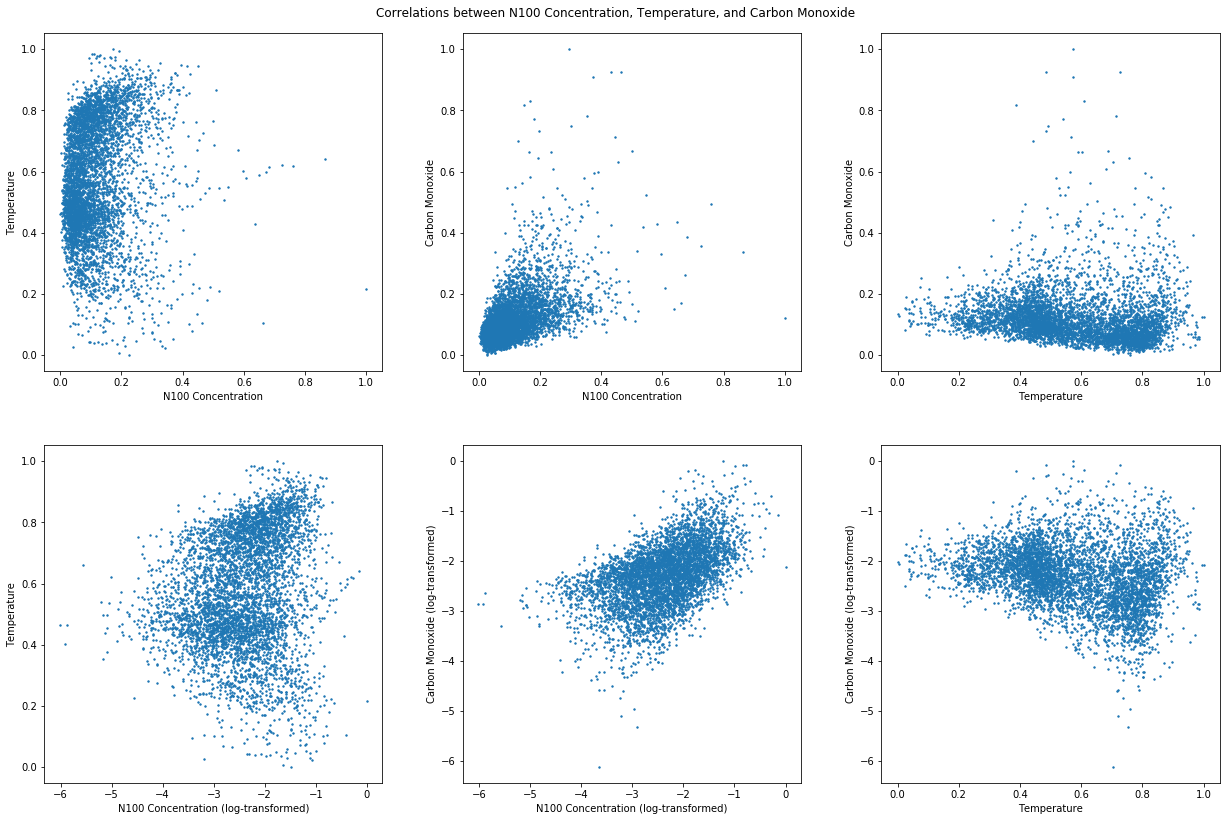

In [10]:
# plotting correlations of variables
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(18,12)
fig.suptitle('Correlations between N100 Concentration, Temperature, and Carbon Monoxide')

ax[0, 0].scatter(df_scaled.concentration, df_scaled.t, s=2)
ax[0, 1].scatter(df_scaled.concentration, df_scaled.co, s=2)
ax[0, 2].scatter(df_scaled.t, df_scaled.co, s=2)

ax[1, 0].scatter(df_log.concentration, df_scaled.t, s=2)
ax[1, 1].scatter(df_log.concentration, df_log.co, s=2)
ax[1, 2].scatter(df_scaled.t, df_log.co, s=2)

for i in range(2):
    n100 = 'N100 Concentration'
    t = 'Temperature'
    co = 'Carbon Monoxide'
    
    if i == 1:
        log = ' (log-transformed)'
        n100 += log
        co += log
    
    ax[i, 0].set_xlabel(n100)
    ax[i, 1].set_xlabel(n100)
    ax[i, 2].set_xlabel(t)

    ax[i, 0].set_ylabel(t)
    ax[i, 1].set_ylabel(co)
    ax[i, 2].set_ylabel(co)
    
fig.tight_layout(pad=4);

In [11]:
# calculating correlation coefficients
pr = 4  # precision

print('NORMALIZED DATA')
print('Correlations between...')
print('\tN100 and T:',
      np.round(np.corrcoef(df_scaled.concentration, df_scaled.t)[0,1], pr))
print('\tN100 and CO:',
      np.round(np.corrcoef(df_scaled.concentration, df_scaled.co)[0,1], pr))
print('\tT and CO:',
      np.round(np.corrcoef(df_scaled.t, df_scaled.co)[0,1], pr))

print('\n')
print('LOG-TRANSFORMED DATA (N100 and CO)')
print('Correlations between...')
print('\tN100 and T:',
      np.round(np.corrcoef(df_log_subset.concentration, df_scaled_subset.t)[0,1], pr))
print('\tN100 and CO:',
      np.round(np.corrcoef(df_log_subset.concentration, df_log_subset.co)[0,1], pr))
print('\tT and CO:',
      np.round(np.corrcoef(df_scaled_subset.t, df_log_subset.co)[0,1], pr))

NORMALIZED DATA
Correlations between...
	N100 and T: 0.1286
	N100 and CO: 0.508
	T and CO: -0.1091


LOG-TRANSFORMED DATA (N100 and CO)
Correlations between...
	N100 and T: 0.1775
	N100 and CO: 0.5039
	T and CO: -0.2429


Using the log-transform actually made the correlations stronger. (When also using a log-transform for the temperature data the correlation was weakened.)

##### Notes:
* use precipitation data?
* use data from previous days?

### Simple Scikit Learn Models

In [108]:
df_comb = pd.DataFrame(np.array([df_log.concentration, df_scaled.t, df_log.co]).T)
df_comb.columns = df.columns.values
df_comb.head()

,concentration,t,co
0,-2.428784,0.406259,-2.012946
1,-3.196716,0.430218,-2.031882
2,-3.614992,0.430934,-2.150360
3,-3.443997,0.392967,-1.922431
4,-3.094905,0.425755,-1.910210


In [109]:
# splitting the data into training, testing, and validation sets
split = int(len(df_comb) * 0.75)

y_train, y_test = df_comb.concentration[0:split], df.concentration[split:len(df)]
y_test = y_test.reset_index(drop=True)

X_train = df_comb[['t', 'co']][0:split]
X_test = df_comb[['t', 'co']][split:len(df_comb)]
X_test = X_test.reset_index(drop=True)

In [110]:
# concentration and co each have one -inf value in one of the rows where df_scaled has value 0
# removing these rows

test_mask = np.isinf(X_test).any(axis=1) == False
X_test = X_test.loc[test_mask]
y_test = y_test.loc[test_mask]

train_mask = np.isinf(X_train).any(axis=1) == False
X_train = X_test.loc[train_mask]
y_train = y_test.loc[train_mask]

In [111]:
# fitting a min_max_scaler to the concentration data
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler = min_max_scaler.fit(df.concentration.values.reshape(-1,1))

In [131]:
# Linear Regression
model = LinearRegression().fit(X_train, y_train)
predictions = model.predict(X_test)

In [135]:
predictions = predictions/100  # scaling?

In [136]:
predictions_new = np.exp(predictions)

In [137]:
predictions[np.isinf(predictions_new)]

array([], dtype=float64)

In [142]:
np.exp(1/100)

1.010050167084168

In [141]:
min_max_scaler.inverse_transform(np.array(1/100).reshape(-1,1))

array([[132.53253833]])

In [140]:
min_max_scaler.inverse_transform(np.array(predictions).reshape(-1,1))

array([[424.29936366],
       [472.27542555],
       [359.35942677],
       ...,
       [373.90187867],
       [424.95307511],
       [384.56269273]])

In [139]:
y_test

0        675.541875
1        939.747639
2        689.660486
3        601.779583
4        776.819514
5        427.080069
6        493.220278
7        591.799792
8        649.457917
9        792.297014
10       530.718112
11       729.613333
12       472.909583
13       694.082797
14       517.090069
15       501.365347
16       706.135556
17       458.070833
18       519.449028
19       909.465139
20       408.689861
21       711.303472
22      1197.224097
23       448.587292
24       351.221875
25       265.061042
26       515.087361
27       608.586458
28       579.478671
29      1107.853681
           ...     
1236     474.406918
1237     399.319932
1238     616.824452
1239     973.434726
1240     630.639945
1241     102.337562
1242     352.621226
1243     525.098288
1244     390.548630
1245     399.067534
1246     454.477529
1247     503.972603
1248     392.234247
1249     243.197862
1250     388.681438
1251     439.929658
1252     345.478219
1253     464.956233
1254     715.456438


In [ ]:
predictions = min_max_scaler.inverse_transform(predictions)

error = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE on test set: %.3f' % error)

plt.figure(figsize=(15,5))
plt.title('Performance of Linear Regression Model - Test Set')
plt.plot(np.array(y_test), label='Observed')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.xlabel('Time step')
plt.ylabel('Log-transform of N100 concentration');

RMSE on test set: 0.042


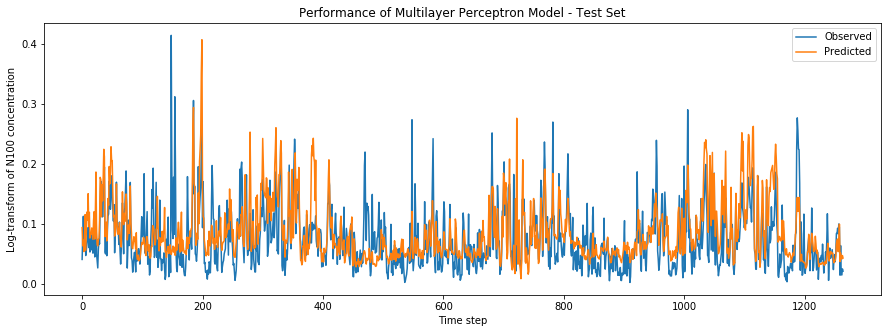

In [59]:
# Multilayer Perceptron
model = MLPRegressor(early_stopping=True).fit(X_train, y_train)
predictions = model.predict(X_test)
predictions = np.exp(predictions)

error = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE on test set: %.3f' % error)

plt.figure(figsize=(15,5))
plt.title('Performance of Multilayer Perceptron Model - Test Set')
plt.plot(np.array(y_test), label='Observed')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.xlabel('Time step')
plt.ylabel('Log-transform of N100 concentration');

C:\Users\ellar\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


RMSE on test set: 0.046


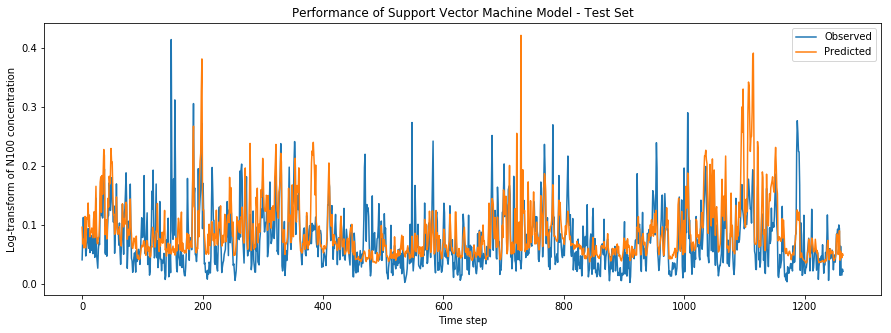

In [60]:
# Support Vector Machine
model = svm.SVR().fit(X_train, y_train)
predictions = model.predict(X_test)
predictions = np.exp(predictions)

error = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE on test set: %.3f' % error)

plt.figure(figsize=(15,5))
plt.title('Performance of Support Vector Machine Model - Test Set')
plt.plot(np.array(y_test), label='Observed')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.xlabel('Time step')
plt.ylabel('Log-transform of N100 concentration');

RMSE on test set: 0.048


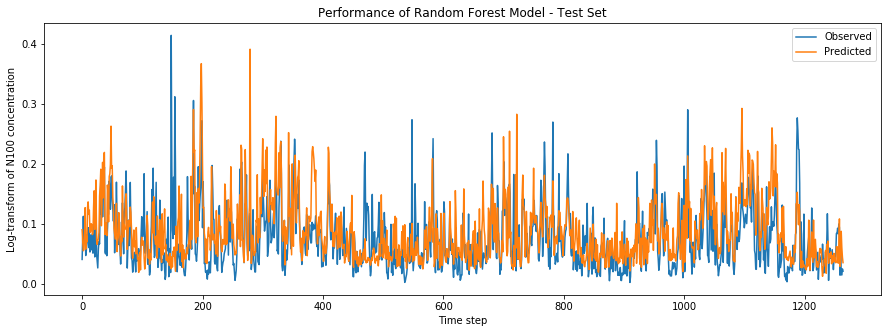

In [61]:
# Random Forest
model = RandomForestRegressor(n_estimators=15).fit(X_train, y_train)
predictions = model.predict(X_test)
predictions = np.exp(predictions)

error = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE on test set: %.3f' % error)

plt.figure(figsize=(15,5))
plt.title('Performance of Random Forest Model - Test Set')
plt.plot(np.array(y_test), label='Observed')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.xlabel('Time step')
plt.ylabel('Log-transform of N100 concentration');